In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import kagglehub

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.callbacks import EarlyStopping
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



---


#DATA PREPARATION


---



In [ ]:
path = kagglehub.dataset_download("yasserh/twitter-tweets-sentiment-dataset")
PATHabs = path + '/Tweets.csv'
tweets = pd.read_csv(PATHabs)
tweets.drop_duplicates(inplace=True)
tweets.dropna(inplace=True)
tweets.info()

100%|██████████| 1.23M/1.23M [00:00<00:00, 35.0MB/s]

Extracting files...


<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


In [ ]:
tweets.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
tweets.drop(columns=['textID', 'selected_text'], inplace=True)
tweets['sentiment'].value_counts()

,count
sentiment,
neutral,11117
positive,8582
negative,7781


**Removing stopwords, punctuation marks, URLs, lemmatization and converting to lowercase**

In [ ]:
spacy_nlp  = spacy.load('en_core_web_sm')
tweets['text'] = tweets['text'].apply(lambda x: x.lower())
tweets['text'] = tweets['text'].apply(lambda x: re.sub( '((www\.[^\s]+)|(https?://[^\s]+))', ' ', x))
tweets['filtered'] = tweets['text'].apply(lambda x: ' '.join(word.lemma_ for word in spacy_nlp(x) if not word.is_stop and not word.is_punct))
tweets.sample(5)

,text,sentiment,filtered
21131,late night...finally home.,neutral,late night finally home
13815,sounds like a perfect way to spend a sunday e...,positive,sound like perfect way spend sunday evening ...
18721,thunder & lightning scarededededed me!,negative,thunder lightning scaredededede
11540,first time in weeks to see the clear blue sky,neutral,time week clear blue sky
5003,really? i can only go in 1direction at a time?...,neutral,1direction time ugh get to authority time 2d...


In [ ]:
tweets['text'] = tweets['filtered']
tweets.drop(columns=['filtered'], inplace=True)



---

#LANGUAGE MODEL


---



**Tokenization**

In [ ]:
tweetsRNN = tweets.copy()
max_features = 3000
tokenizer = Tokenizer(num_words=max_features, split=' ')
tokenizer.fit_on_texts(tweetsRNN['text'].values)

**Split 80/20**

In [ ]:
X_trainRNN, X_testRNN, y_trainRNN, y_testRNN = train_test_split(tweetsRNN['text'], tweetsRNN['sentiment'], test_size=0.2, random_state=69, stratify=tweets['sentiment'])

**Tweets length distribution**

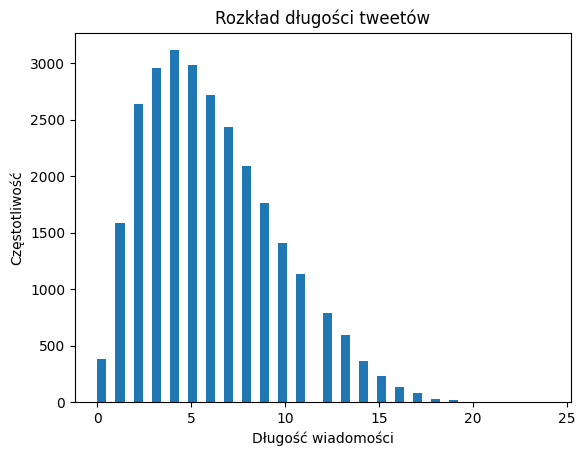

In [ ]:
lengths = [len(seq) for seq in tokenizer.texts_to_sequences(tweets['text'])]
plt.hist(lengths, bins=50)
plt.xlabel('Długość wiadomości')
plt.ylabel('Częstotliwość')
plt.title('Rozkład długości tweetów')
plt.show()

**Vectorization and padding**

In [ ]:
X_vectTrainRNN = tokenizer.texts_to_sequences(X_trainRNN)
X_vectTrainRNN = pad_sequences(X_vectTrainRNN)
X_vectTestRNN = tokenizer.texts_to_sequences(X_testRNN)
X_vectTestRNN = pad_sequences(X_vectTestRNN)

In [ ]:
X_vectTestRNN = np.lib.pad(X_vectTestRNN, ((0,0), (X_vectTrainRNN.shape[1] - X_vectTestRNN.shape[1], 0)), 'constant', constant_values=(0))
[X_vectTrainRNN.shape, X_vectTestRNN.shape]

[(21984, 24), (5496, 24)]

**One-hot encoding**

In [ ]:
y_trainRNN = pd.get_dummies(y_trainRNN)
y_testRNN = pd.get_dummies(y_testRNN)

**Preserving labels**

In [ ]:
classes = y_testRNN.columns.tolist()

In [ ]:
y_trainRNN = np.array(y_trainRNN)
y_testRNN = np.array(y_testRNN)

**Model**

In [ ]:
max_features = 3000
batch_size = 64
epochs = 20
embed_dim = 128
ltsm = 256

early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model = Sequential()
model.add(Embedding(max_features, embed_dim, input_length=X_vectTrainRNN.shape[1]))
model.add(LSTM(ltsm, dropout=0.7, recurrent_dropout=0.7))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


**Training**

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [ ]:
history = model.fit(X_vectTrainRNN, y_trainRNN, validation_split=0.1,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=[early_stopping],
                    verbose=2)


Epoch 1/20
310/310 - 47s - 151ms/step - accuracy: 0.5445 - loss: 0.9361 - val_accuracy: 0.6771 - val_loss: 0.7675
Epoch 2/20
310/310 - 40s - 129ms/step - accuracy: 0.6855 - loss: 0.7464 - val_accuracy: 0.6971 - val_loss: 0.7166
Epoch 3/20
310/310 - 43s - 138ms/step - accuracy: 0.7214 - loss: 0.6828 - val_accuracy: 0.7140 - val_loss: 0.6941
Epoch 4/20
310/310 - 82s - 265ms/step - accuracy: 0.7425 - loss: 0.6466 - val_accuracy: 0.7112 - val_loss: 0.6958
Epoch 5/20
310/310 - 81s - 260ms/step - accuracy: 0.7520 - loss: 0.6229 - val_accuracy: 0.7171 - val_loss: 0.6836
Epoch 6/20
310/310 - 42s - 135ms/step - accuracy: 0.7659 - loss: 0.5972 - val_accuracy: 0.7158 - val_loss: 0.6900
Epoch 7/20
310/310 - 43s - 138ms/step - accuracy: 0.7698 - loss: 0.5866 - val_accuracy: 0.7194 - val_loss: 0.6967


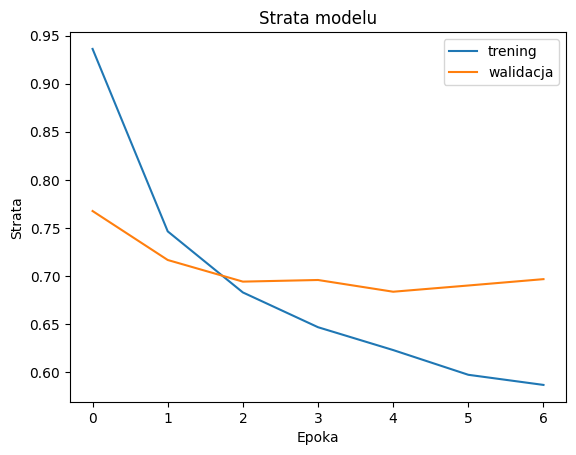

In [ ]:
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 24, 128)             │         384,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 256)                 │         394,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             771 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,337,035 (8.92 MB)

 Trainable params: 779,011 (2.97 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,558,024 (5.94 MB)



---

#SVM

---



**Preserving labels**

In [ ]:
le = LabelEncoder()
tweets['sentiment'] = le.fit_transform(tweets['sentiment'])
classesLE = le.inverse_transform([0,1,2])

**Split 80/20**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(tweets['text'], tweets['sentiment'], test_size = 0.2, random_state=69, stratify=tweets['sentiment'])

**TF-IDF vectorization**

In [ ]:
vect = TfidfVectorizer()
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

**Grid search**

In [ ]:
#param_grid = {'C': [0.1, 1, 10], 'gamma': [0.1, 1, 'scale', 'auto'], 'kernel': ['rbf', 'linear', 'poly']}
#svm = GridSearchCV(SVC(), param_grid, cv=5, verbose=3)
#svm.fit(X_train, y_train)

In [ ]:
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

SVC(kernel='linear')



---


#MODEL COMPARISON


---



In [ ]:
y_pred_prob = model.predict(X_vectTestRNN, batch_size=batch_size, verbose=0)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_testRNN, axis=1)
svm_pred = svm.predict(X_test)

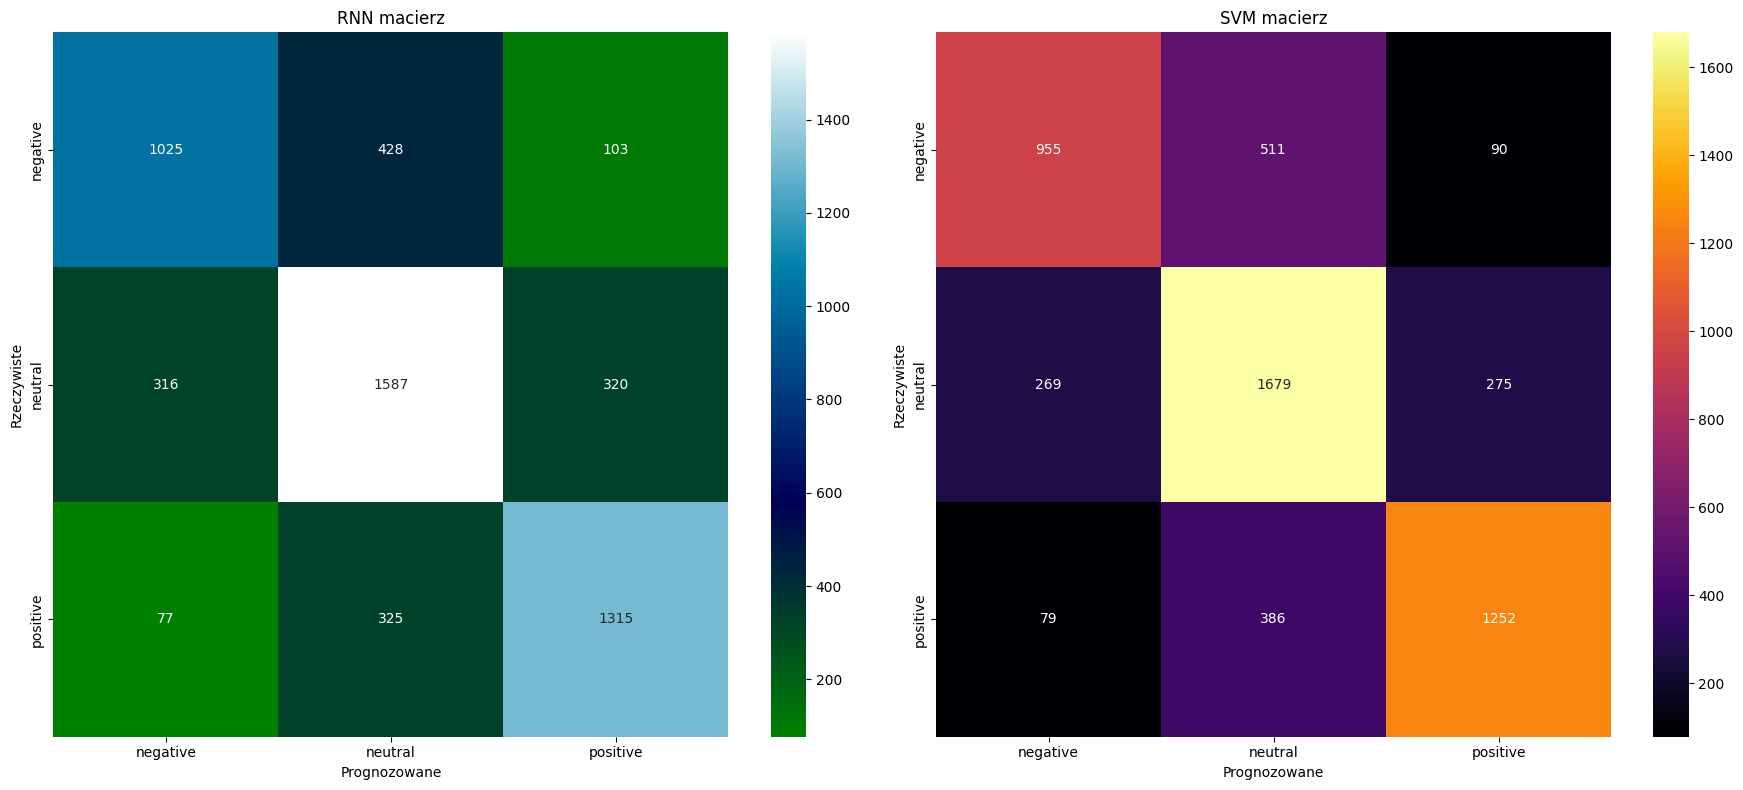

RNN Classification Report                                                                                                                                                               SVM Classification Report
-----------------------------------------------------                                                                                                       -----------------------------------------------------
              precision    recall  f1-score   support                                                                                                                     precision    recall  f1-score   support
                                                                                                                                                                                       
    negative       0.72      0.66      0.69      1556                                                                                                           negative       0.73      0

In [ ]:
rnn_cm = confusion_matrix(y_true, y_pred)
svm_cm = confusion_matrix(y_test, svm_pred)

rnn_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
svm_report = classification_report(y_test, svm_pred, target_names=classesLE, output_dict=True)


fig, axes = plt.subplots(1, 2, figsize=(18, 8))

#RNN
sns.heatmap(rnn_cm, annot=True, fmt='d', cmap='ocean', xticklabels=classes,
            yticklabels=classes, ax=axes[0])
axes[0].set_title('RNN matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

#SVM
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='inferno', xticklabels=classesLE,
            yticklabels=classesLE, ax=axes[1])
axes[1].set_title('SVM matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')


plt.tight_layout()
plt.show()

#ALL
rnn_report = classification_report(y_true, y_pred, target_names=classes)
svm_report = classification_report(y_test, svm_pred, target_names=classesLE)


rnn_lines = rnn_report.split('\n')
svm_lines = svm_report.split('\n')


print(f"{'RNN Classification Report':<40} {'SVM Classification Report':>168}")
print(f"{'-'*53}{' '*103}{'-'*53}")


for rnn_line, svm_line in zip(rnn_lines, svm_lines):
    print(f"{rnn_line:<40}{' '*103}{svm_line:<40}")